In [1]:
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
from sklearn.decomposition import PCA
import warnings
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import random
import math
import pandas as pd
import umap
from scipy.spatial import ConvexHull
from functools import reduce
import numpy as np
warnings.filterwarnings("ignore")
#from joblib import dump, load

In [2]:
ld = datasets.load_digits()
x = scale(ld.data, axis=0)
y = ld.target

In [3]:
x.shape

(1797, 64)

In [4]:
ln = len(set(y))
ln

10

In [5]:
y.shape

(1797,)

In [6]:
x[0],y[0]

(array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
        -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
         0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
        -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
        -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
         0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
         1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
        -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
        -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
         0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
         1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
        -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
        -0.36677122, -1.14664746, -0.5056698 , -0.19600752]),
 0)

In [27]:
class MyKMeans(KMeans):
    
    def __init__(self, init, n_clusters):
        super().__init__(init=init, n_clusters=n_clusters, n_init=10)
    
    def check(self, x, y):
        self.fit(x,y)
        result = self.labels_
        print(f'ARI: {ARI(y, result)}, AMI: {AMI(y, result)}')
    
    def check_plot(self, x, y, plot = True):
        %time self.check(x,y)
        if not plot:
            return None
        um = umap.UMAP(n_components=2, min_dist=0.5)
        x_tsne = um.fit_transform(x)
        x_cent = um.transform(self.cluster_centers_)
        df = pd.DataFrame({'x':x_tsne[:,0],'y':x_tsne[:,1],'label':tuple(map(lambda x: f'class: {x}',y)),'label2':self.labels_})
        fig = go.Figure(layout=go.Layout(template='plotly_dark',height=1000,width=1000))
        for i in df['label2'].unique():
            temp = df.query('label2 == @i')
            fig.add_trace(go.Scatter(x=temp['x'], y=temp['y'], name = f'cluster: {i}',mode='markers',opacity=0.25,marker=dict(size=20)))
        for i in df['label'].unique():
            temp = df.query('label == @i')
            fig.add_trace(go.Scatter(x=temp['x'], y=temp['y'], name = i, mode='markers'))

        fig.add_trace(go.Scatter(x=x_cent[:, 0], y=x_cent[:, 1], mode='markers', marker=dict(size=10, symbol='x', color='white')))

        fig.show()

ARI: 0.559117108035438, AMI: 0.6885829883551786
CPU times: total: 1.47 s
Wall time: 220 ms


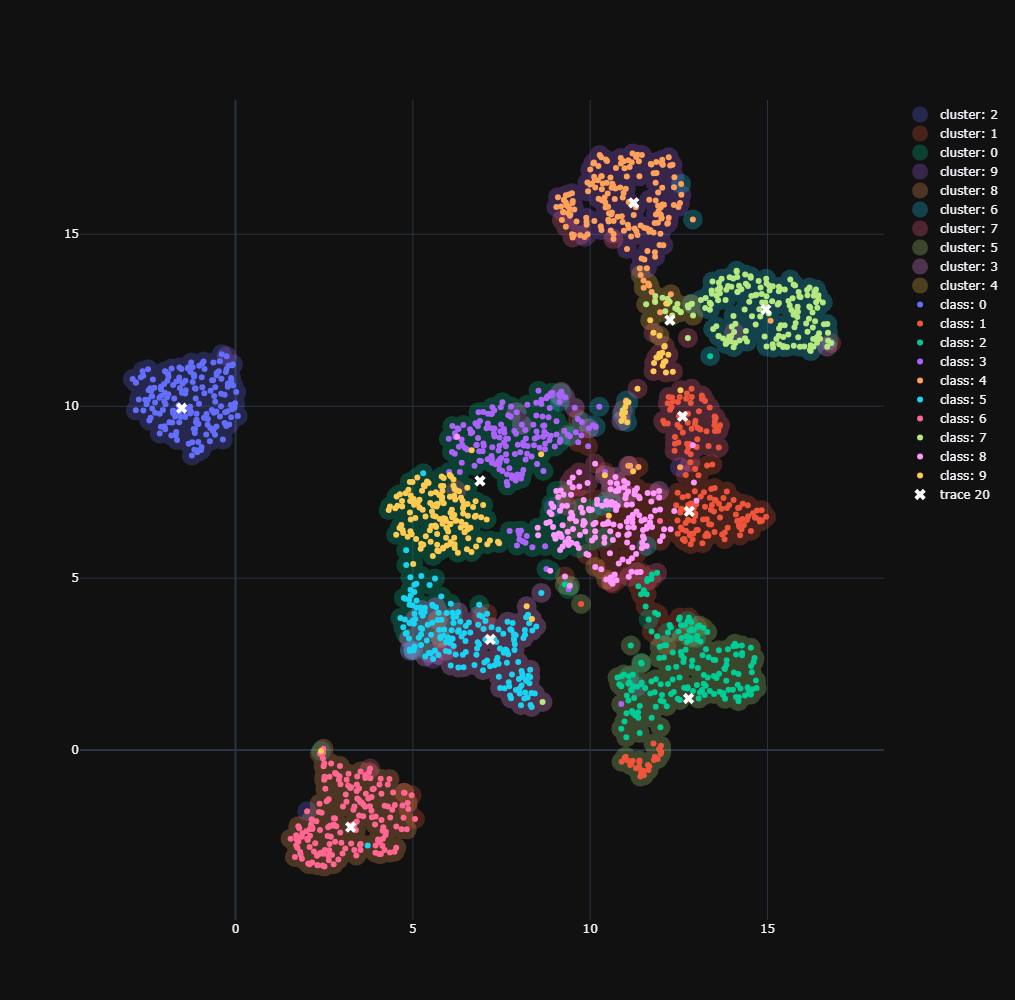

In [28]:
km = MyKMeans(init='k-means++', n_clusters=ln)
km.check_plot(x, y)

ARI: 0.5717546912473017, AMI: 0.6985257212149927
CPU times: total: 938 ms
Wall time: 186 ms


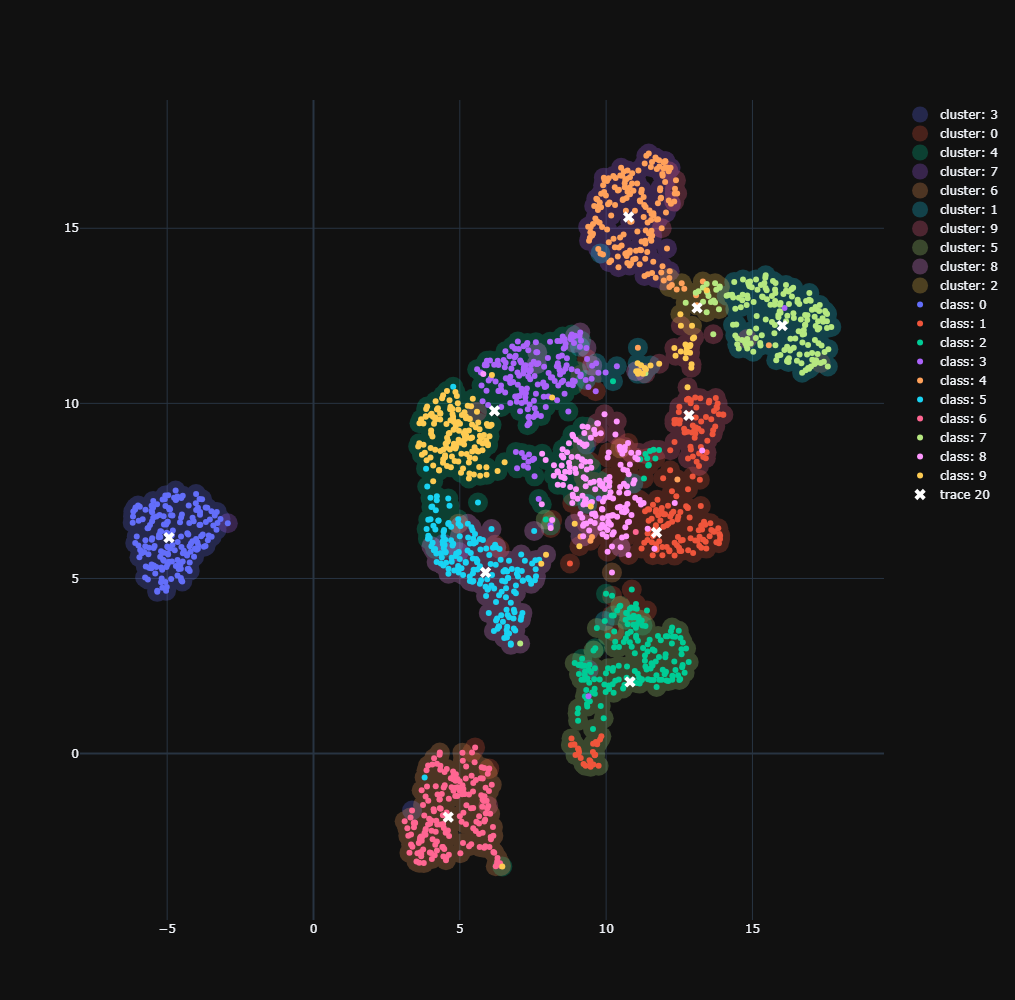

In [35]:
km = MyKMeans(init='random', n_clusters=ln)
km.check_plot(x, y)

In [19]:
pca = PCA(n_components=ln).fit(x)

ARI: 0.356592352622042, AMI: 0.48771085490362326
CPU times: total: 125 ms
Wall time: 21 ms


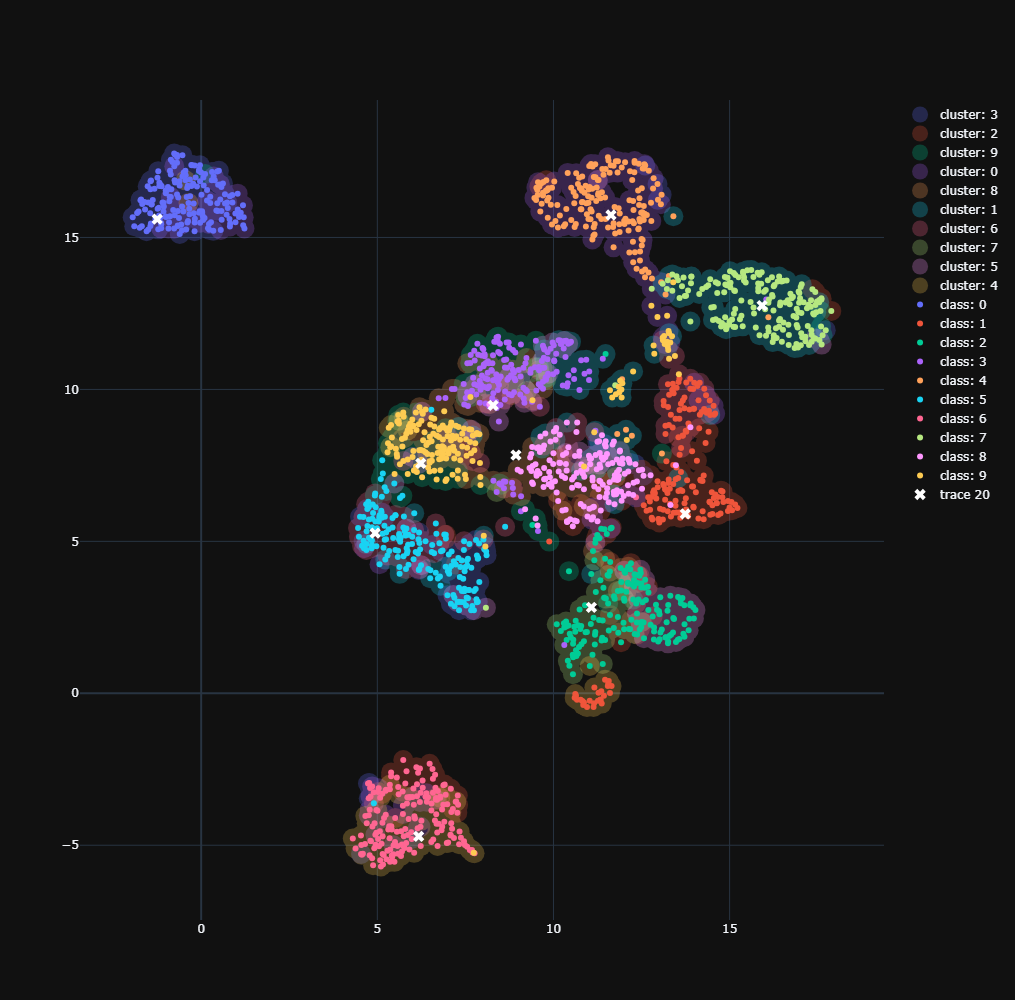

In [20]:
km = MyKMeans(init=pca.components_, n_clusters=ln)
km.check_plot(x, y)

In [44]:
class Node():
    __slots__ = ('coord', 'cl')
    
    def __init__(self, coord):
        self.coord = tuple(coord)
        self.cl = None
        
    def make_cent(self):
        return Cent(self.coord)
    
    def __getitem__(self, indx):
        return self.coord[indx]
        
        
class Cent(Node):
    __slots__ = ('coord', 'id', 'pool', 'n')
    uid = 0
    
    def __new__(cls, args):
        inst = object.__new__(cls)
        inst.id = cls.uid
        cls.uid += 1
        return inst
    
    def __init__(self, coord):
        self.coord = tuple(coord)
        self.null_pool()
    
    @staticmethod
    def r(a, b):
        return math.sqrt(reduce(lambda x, y: x + math.pow((b[y]-a[y]), 2), range(len(a)), 0))
    
    def length(self, other):
        return self.r(self.coord, other)
    
    def __add__(self, other):
        self.pool = tuple(map(sum, zip(self.pool, other)))
        self.n += 1
        return self
    
    def new_coord(self):
        self.coord = tuple(map(lambda x: x/self.n, self.pool))
        self.null_pool()
        
    def null_pool(self):
        self.pool = tuple([0]*len(self.coord))
        self.n = 0
    
        
class ReallyMyKmeans:
    __slots__ = ('ten', 'list','epsilon')
    
    def __init__(self, ten, k, epsilon=1e-4):
        self.epsilon = epsilon
        self.ten = list(Node(x) for x in ten)
        self.list = list(map(lambda x: x.make_cent(), random.sample(self.ten, k)))
    
    # def f(self,x):
    #     x,y=x
    #     return abs(x-y) <= self.epsilon
    def f(self,x,y):
        return reduce(lambda x,y : x+(y[0]-y[1])**2,zip(x,y),0)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        # переопределим принадлежность точек к кластерам, а также занесем в пул их значение
        for i in self.ten:
            rr = math.inf
            temp = None
            for q in self.list:
                r = q.length(i)
                if r < rr:
                    rr = r
                    i.cl = q.id
                    temp = q
            temp = temp+i
        # изменение центра тяжести кластера и проверка на установление центроиды
        res = True
        for i in self.list: 
            temp = i.coord
            i.new_coord()
            # res &= all(map(self.f,zip(temp,i.coord)))
            res &= self.f(temp, i.coord) < self.epsilon
        if res:
            raise StopIteration
        
    def fit(self, y):
        for _ in self:
            pass
        result = tuple(map(lambda x: x.cl, self.ten))
        #print(result)
        #print(tuple(map(lambda x: x.cl, self.ten)))
        print(f'ARI: {ARI(y, result)}, AMI: {AMI(y, result)}')
            
    def check(self, y):
        %time self.fit(y)
#         x_tsne =TSNE().fit_transform(self.ten)
#         x_tsne, x_cent = x_tsne[:-self.n_clusters], x_tsne[-self.n_clusters:]
#         px.scatter(x=x_tsne[:, 0], y=x_tsne[:, 1], color=tuple(map(lambda x: f'class: {x}',y)),title='TSNE',width=1000,height=600).show()

In [45]:
km = MyKMeans(init='random', n_clusters=ln)
km.check_plot(x, y, plot=False)
km = ReallyMyKmeans(x, ln)
km.check(y)

ARI: 0.5724627213366836, AMI: 0.697042818643168
CPU times: total: 1.52 s
Wall time: 221 ms
ARI: 0.5312183565491319, AMI: 0.6577144960827142
CPU times: total: 28.3 s
Wall time: 27.8 s


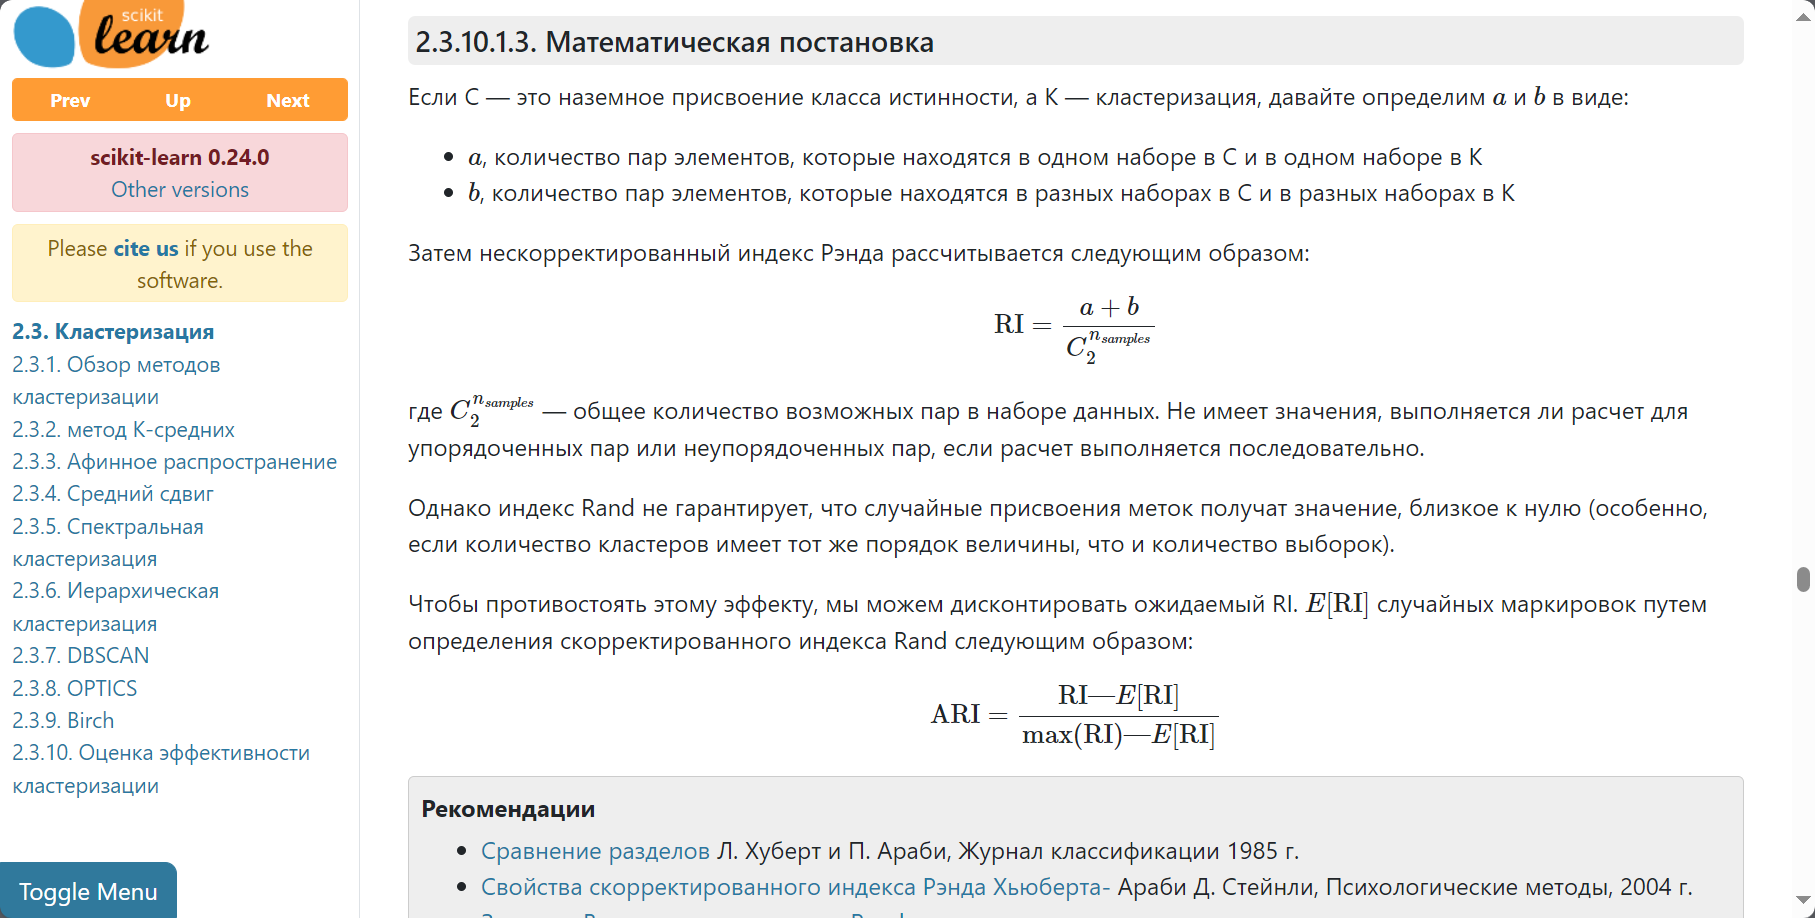

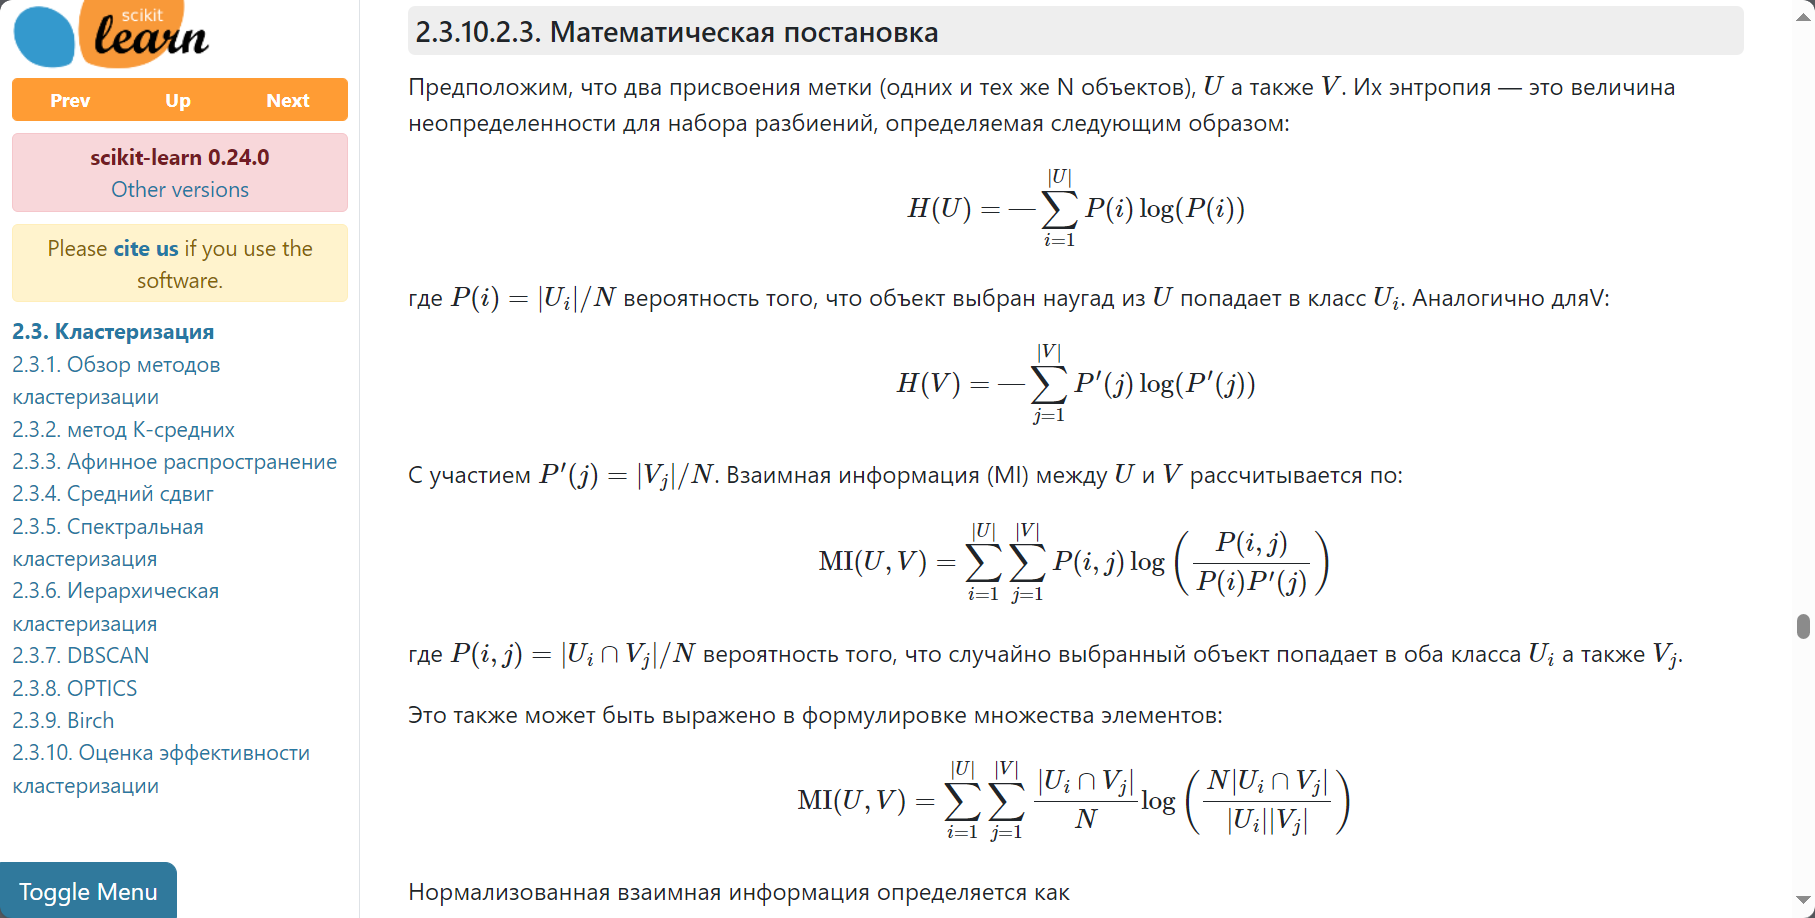

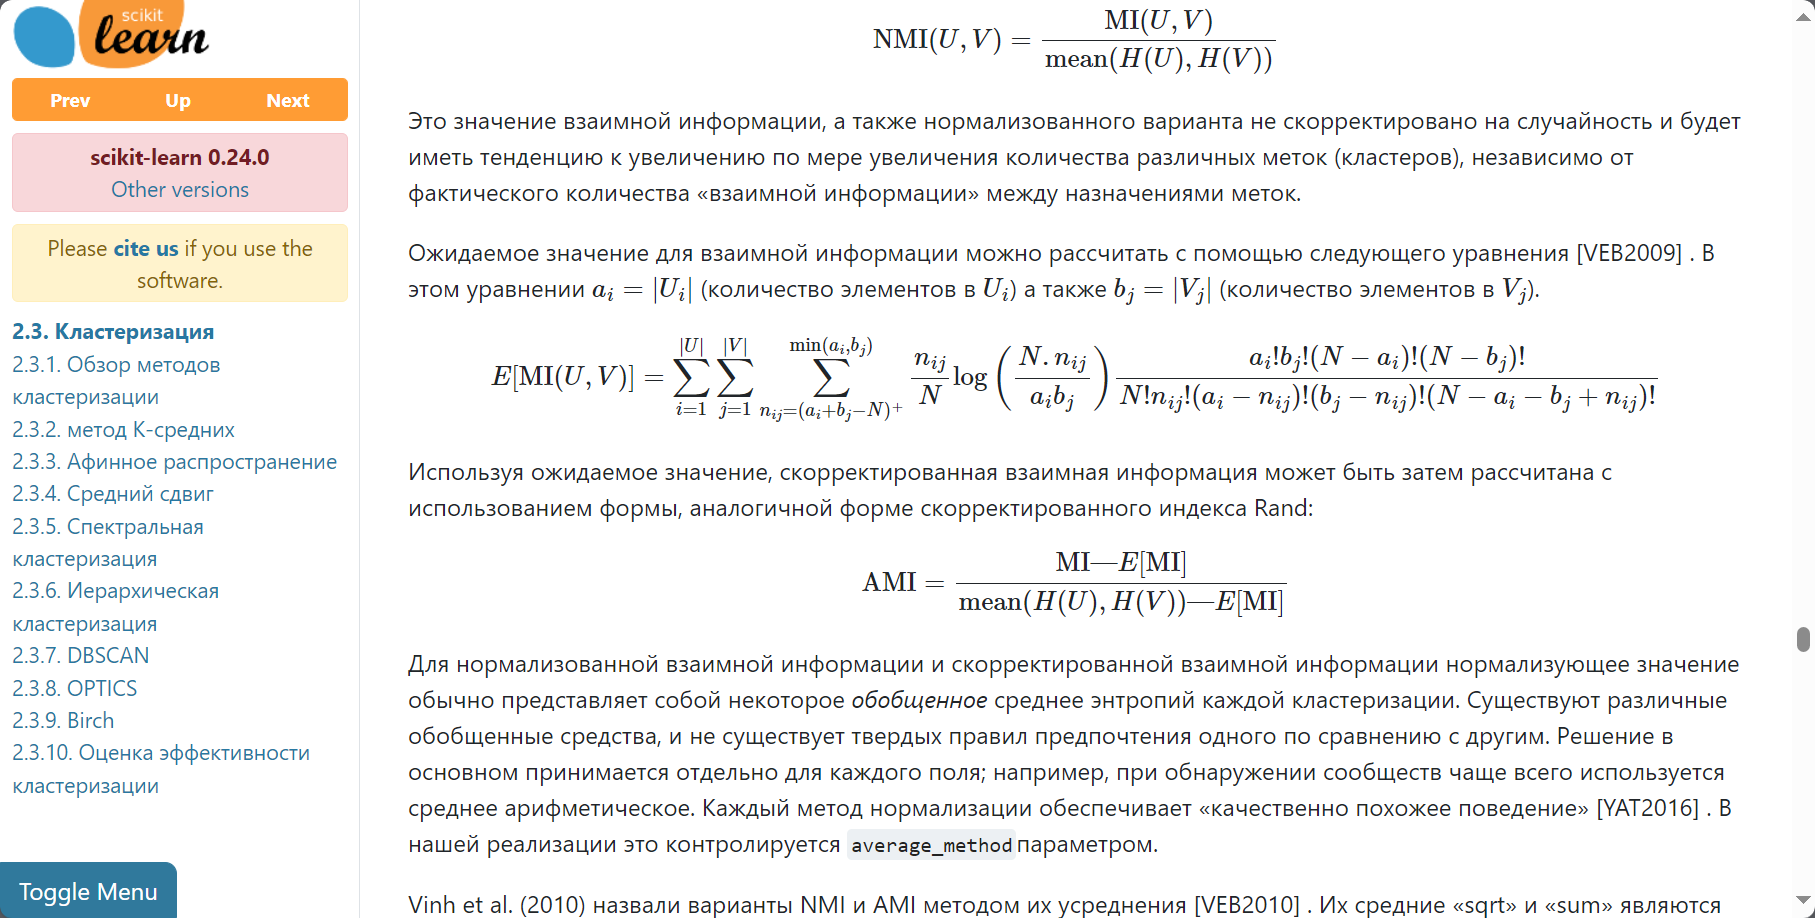